# Project Overview — Diabetes Risk Prediction (Notebook Roadmap)
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade

**Purpose:**
This notebook builds a production-oriented, interpretable machine-learning pipeline to predict diabetes risk (target: `Diabetes Status` 0/1) from patient demographic and clinical features. It is written step‑by‑step so each cell can be executed sequentially, audited, and reused by data scientists and healthcare professionals.

**Stakeholders:** Ministry of Public Health, clinical teams, data science team, ML engineers, and auditors/regulators.

---

## Dataset (high level)

Key features provided in the dataset:

* **Gender:** categorical (`male`, `female`, `other`).
* **Age:** numeric (0–80).
* **Hypertension:** binary (0/1).
* **Heart Disease:** binary (0/1).
* **Smoking History:** categorical (`not current`, `former`, `no info`, `current`, `never`, `ever`).
* **BMI:** numeric (10.16–71.55) — will also create BMI category flags (underweight/normal/overweight/obese).
* **HbA1c Level:** numeric (clinical threshold > 6.5% useful for flags).
* **Blood Glucose Level:** numeric (snapshot glucose).
* **Diabetes Status:** target (0 = no, 1 = yes).

---

## Primary objectives & acceptance criteria

* Deliver an **accurate** and **interpretable** predictive model that meets clinical-quality thresholds (target baseline: **≥ 85% accuracy** with balanced precision/recall). Priority: **high recall (sensitivity)** to reduce false negatives.
* Produce **explainable predictions** (SHAP/LIME) and a model factsheet suitable for regulatory review.
* Implement **reproducible** code, logging, model versioning, and basic deployment artifacts.

---

## Notebook structure — one cell at a time (what to expect)

1. **Project overview (this cell)** — goals, dataset, plan, deliverables.
2. **Environment & reproducibility (code)** — set random seeds, import libraries, show Python and package versions, configure plotting defaults.
3. **Load dataset (code)** — read CSV/Parquet, quick `df.head()` and `df.info()` checks, create a copy for experimentation.
4. **Exploratory Data Analysis (EDA) (code + visuals)** — distributions, class balance, pairwise correlations, missing-data heatmap, clinical threshold visualizations (HbA1c, glucose, BMI).
5. **Data cleaning (code)** — fix datatypes, unify category labels, handle impossible values, treat outliers, and document cleaning decisions.
6. **Missing value strategy (code)** — per-column imputation (domain-aware strategies: median for numeric, special category or `Unknown` for categorical; flag columns with heavy missingness).
7. **Feature engineering (code)** — create BMI categories, age bins, HbA1c/glucose flags, interaction features (e.g., age × BMI), and aggregate indicators (comorbidity score).
8. **Preprocessing pipeline (code)** — `sklearn` `ColumnTransformer` + pipeline: imputers, encoders, scalers. Save pipeline for later production use.
9. **Train/validation/test split (code)** — stratified split, seeds, optional CV folds set up.
10. **Baseline model (code)** — logistic regression with calibration and baseline metrics.
11. **Tree-based models (code)** — Random Forest, XGBoost/LightGBM/CatBoost benches; capture feature importances.
12. **Hyperparameter tuning (code)** — `RandomizedSearchCV` or `GridSearchCV` with stratified CV and scoring focused on recall/AUC.
13. **Model evaluation (code + visuals)** — confusion matrix, classification report, ROC & PR curves, calibration plots, threshold analysis.
14. **Model interpretability (code)** — global and local explanations with SHAP (summary plots, dependence plots) and sample-level explanations for clinicians.
15. **Error & fairness analysis (code)** — review false negatives/positives, subgroup performance (age groups, gender, BMI categories), bias checks and mitigation notes.
16. **Final model selection & saving (code)** — choose final model, serialize model + preprocessing pipeline (joblib), save metadata and model card.
17. **Minimal deployment demo (code)** — example Flask/FastAPI skeleton or `predict()` function showing expected JSON schema and example inputs.
18. **Monitoring & maintenance (markdown + code)** — ideas and simple code for drift detection, logging, scheduled re-training, and alerts.
19. **Documentation & compliance (markdown)** — model factsheet, data lineage, privacy & consent checklist, regulatory considerations (audit trail, explainability requirements).
20. **Appendix & reproducibility (code + markdown)** — `requirements.txt`, seed logs, small tests, and pointers to next steps (clinical validation studies).

---

## Expected deliverables from this notebook

* Reproducible ML pipeline (preprocessing + model).
* Evaluation report (metrics, plots, confusion matrices).
* Model interpretation artifacts (SHAP summary + per-case explanations).
* Exported model and preprocessing pipeline ready for integration.
* Minimal API skeleton and documentation for handoff.

---

## Assumptions & limitations

* Dataset is representative of the target population; if not, cohort biases will be analyzed in the fairness check.
* Clinical thresholds (e.g., HbA1c > 6.5%) are used for feature engineering but final predictions rely on ML outputs and calibrated probabilities.
* This notebook focuses on methodological rigor and reproducibility but **is not** a substitute for clinical trials or regulatory validation.

---

## Next step

Execute the next cell (Environment & reproducibility): imports, seed, and package-version checks. From there we will load the dataset and begin EDA.



In [1]:
# Cell 2 — Environment Setup & Reproducibility
# Environment Setup & Library Imports

# Reproducibility
import os
import random
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)

# Set random seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Plotting defaults
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["font.size"] = 11

# Version check for transparency
import sys
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)



OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [2]:
# Cell 3 — Load Dataset

# Load Dataset

# Define dataset path
data_path = "diabetes_prediction_dataset.csv"  

# Load dataset into a pandas DataFrame
df = pd.read_csv(data_path)

# Quick checks on dataset shape and basic information
print("Dataset shape:", df.shape)
print("\nData Types and Non-Null Counts:")
print(df.info())

# Preview first few rows
display(df.head())


Dataset shape: (100000, 9)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0



Descriptive Statistics:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000



Diabetes Class Distribution:
diabetes
0    91500
1     8500
Name: count, dtype: int64

Class Proportions (%):
diabetes
0    91.5
1     8.5
Name: proportion, dtype: float64


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\695307372.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="diabetes", data=df, palette="Set2")


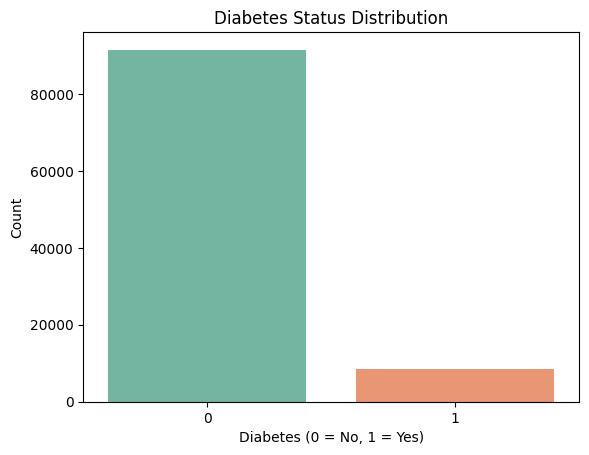

C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\695307372.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="gender", data=df, ax=axes[0], palette="pastel")
C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\695307372.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="smoking_history", data=df, ax=axes[1], order=df["smoking_history"].value_counts().index, palette="pastel")


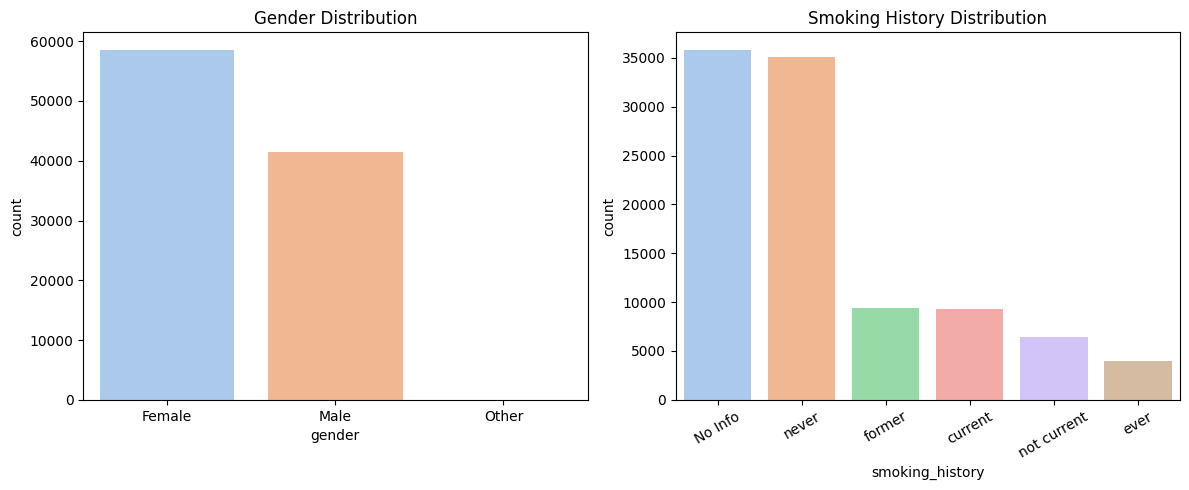

In [3]:
# Cell 4 — Exploratory Data Analysis (EDA: Part 1 — Overview & Target Balance)


# EDA Part 1 — Dataset Overview & Target Variable

# Summary statistics of numerical features
print("\nDescriptive Statistics:")
display(df.describe())

# Class balance for the target variable 'diabetes'
print("\nDiabetes Class Distribution:")
print(df["diabetes"].value_counts())
print("\nClass Proportions (%):")
print(df["diabetes"].value_counts(normalize=True) * 100)

# Visualize target balance
sns.countplot(x="diabetes", data=df, palette="Set2")
plt.title("Diabetes Status Distribution")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Distribution of categorical variables
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x="gender", data=df, ax=axes[0], palette="pastel")
axes[0].set_title("Gender Distribution")

sns.countplot(x="smoking_history", data=df, ax=axes[1], order=df["smoking_history"].value_counts().index, palette="pastel")
axes[1].set_title("Smoking History Distribution")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

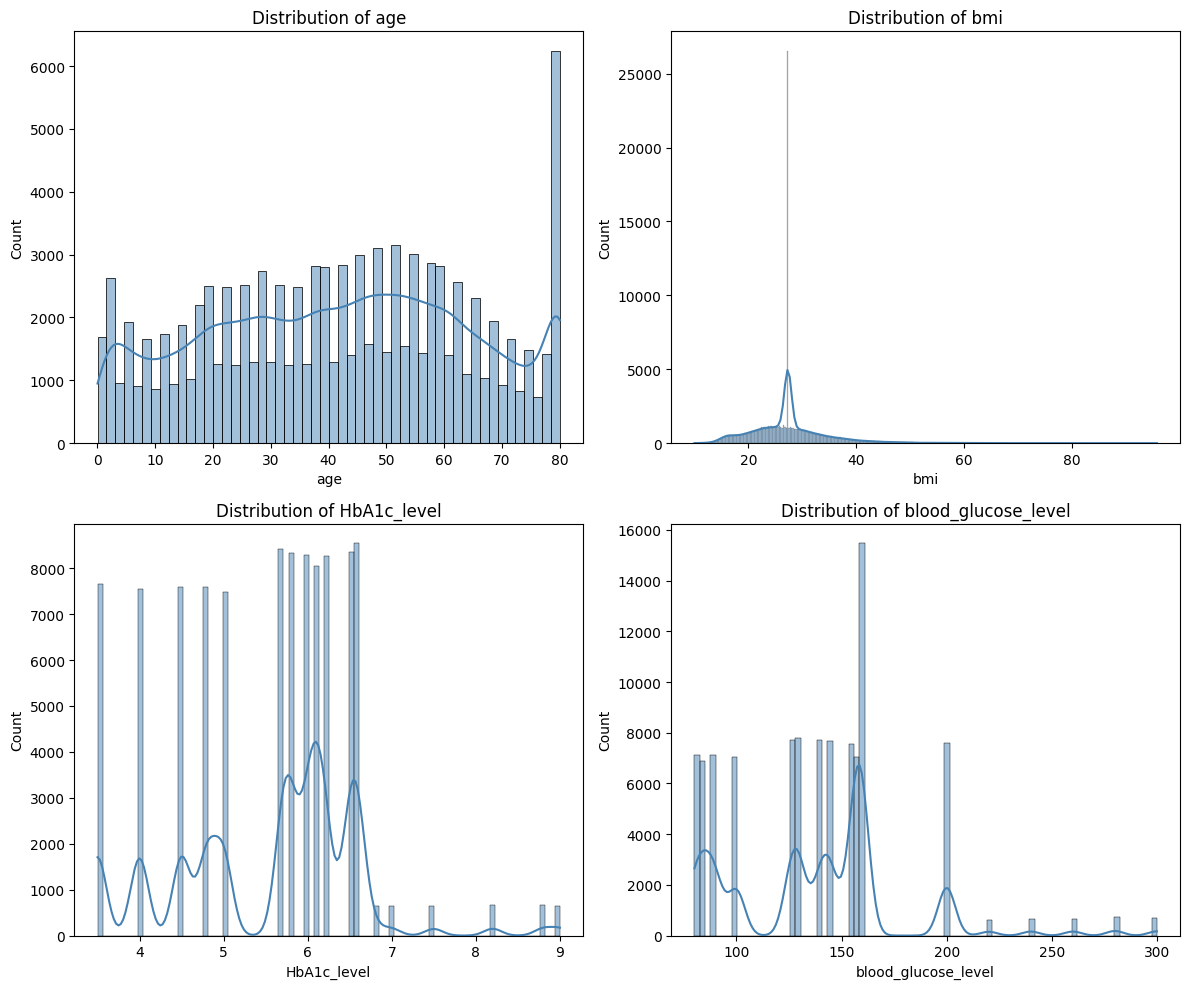

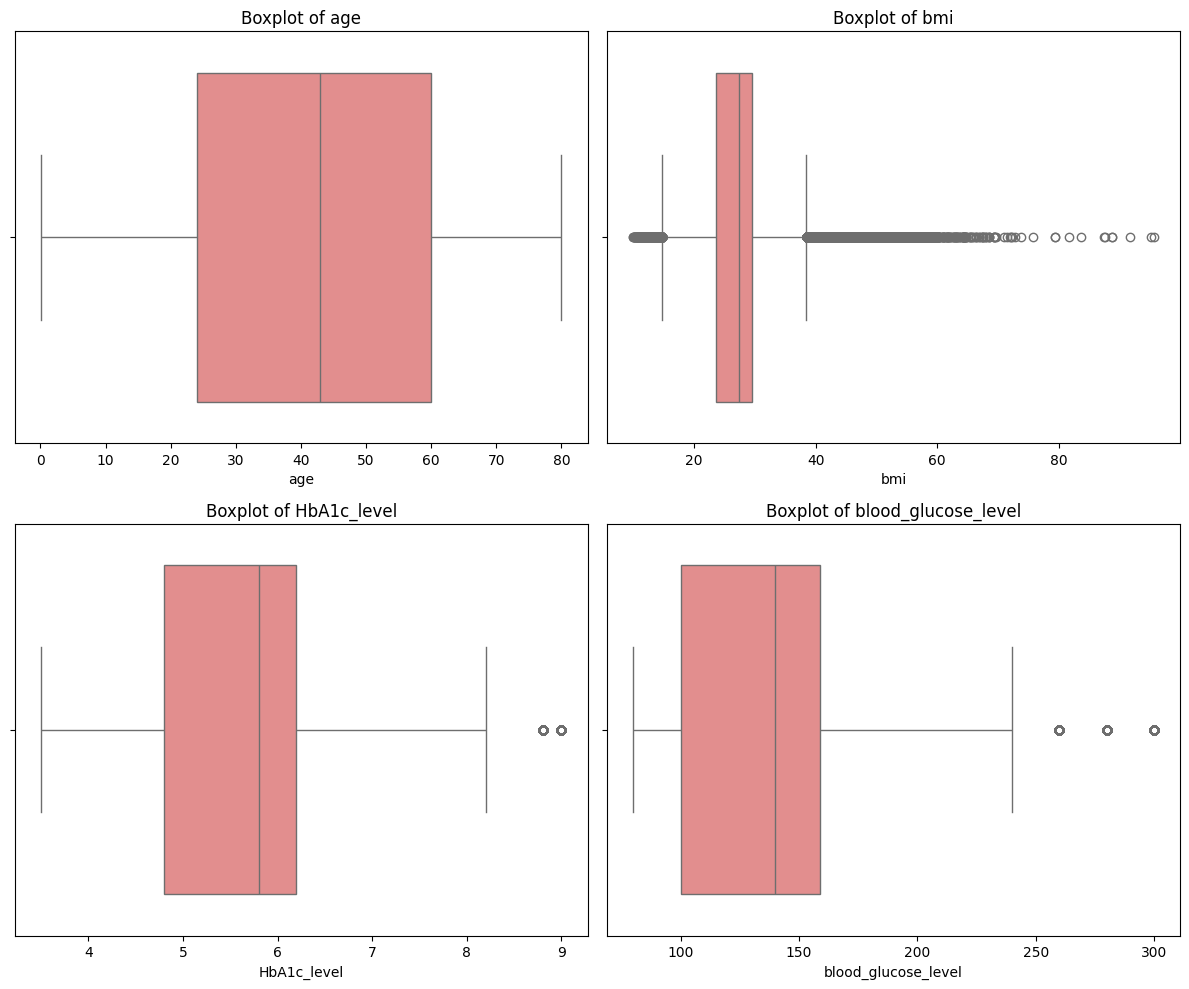

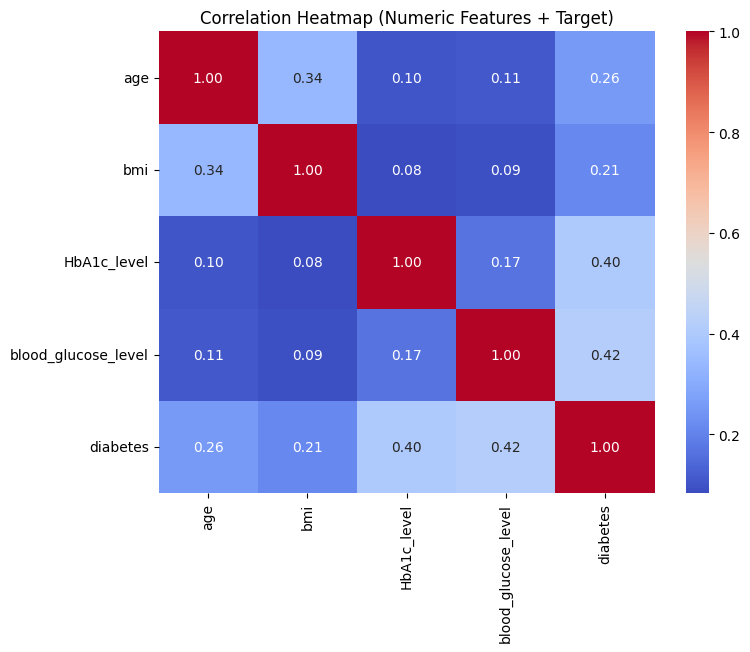

In [6]:
# Cell 5 — Exploratory Data Analysis (EDA: Part 2 — Numerical Distributions & Correlations)
# EDA Part 2 — Numerical Feature Distributions & Correlations
numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

# Histograms & KDE plots for numerical variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[idx//2, idx%2], color="steelblue")
    axes[idx//2, idx%2].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Boxplots to check for outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, col in enumerate(numeric_features):
    sns.boxplot(x=df[col], ax=axes[idx//2, idx%2], color="lightcoral")
    axes[idx//2, idx%2].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric variables
plt.figure(figsize=(8,6))
corr_matrix = df[numeric_features + ["diabetes"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.show()


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\1558786722.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diabetes", y="age", data=df, palette="Set2")


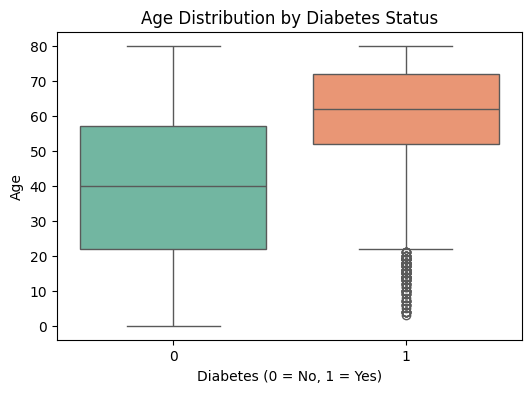

C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\1558786722.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diabetes", y="bmi", data=df, palette="Set2")


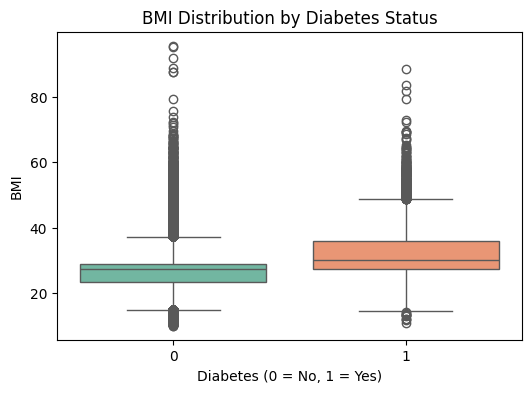

C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\1558786722.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diabetes", y="HbA1c_level", data=df, palette="Set2")


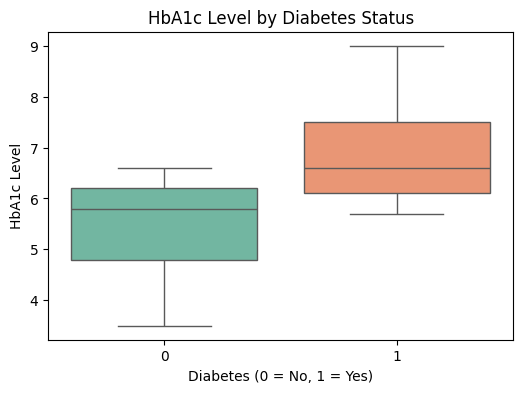

C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_18488\1558786722.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diabetes", y="blood_glucose_level", data=df, palette="Set2")


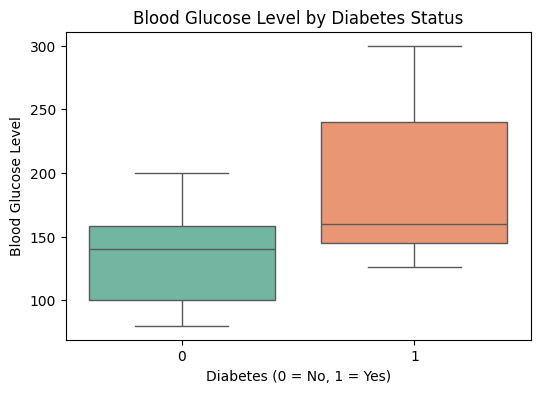

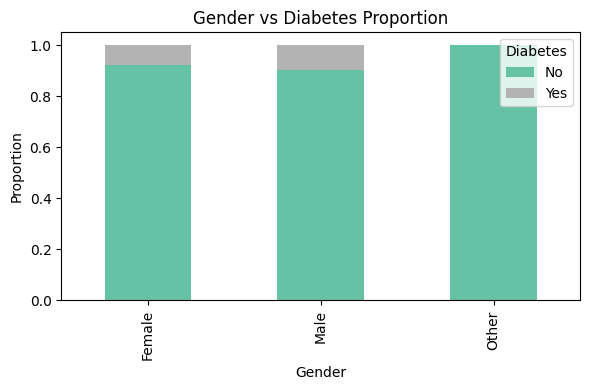

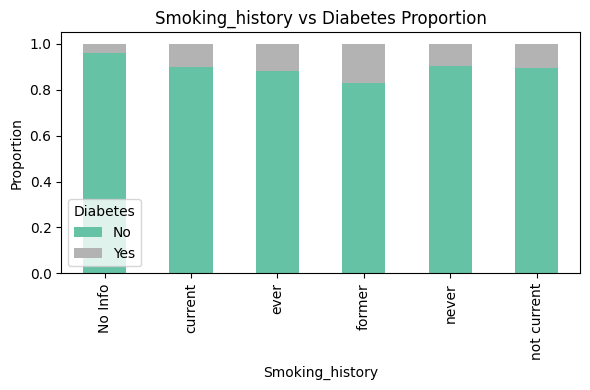

In [7]:
# Cell 6 — Exploratory Data Analysis (EDA: Part 3 — Feature Relationships with Target)
# EDA Part 3 — Relationships Between Features and Target (Diabetes)

# Age vs Diabetes (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x="diabetes", y="age", data=df, palette="Set2")
plt.title("Age Distribution by Diabetes Status")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

# BMI vs Diabetes (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x="diabetes", y="bmi", data=df, palette="Set2")
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("BMI")
plt.show()

# HbA1c vs Diabetes (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x="diabetes", y="HbA1c_level", data=df, palette="Set2")
plt.title("HbA1c Level by Diabetes Status")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("HbA1c Level")
plt.show()

# Blood Glucose vs Diabetes (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x="diabetes", y="blood_glucose_level", data=df, palette="Set2")
plt.title("Blood Glucose Level by Diabetes Status")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Blood Glucose Level")
plt.show()

# Categorical features vs Target (stacked barplots)
categorical_features = ["gender", "smoking_history"]
for col in categorical_features:
    cross_tab = pd.crosstab(df[col], df["diabetes"], normalize="index")
    cross_tab.plot(kind="bar", stacked=True, figsize=(6,4), colormap="Set2")
    plt.title(f"{col.capitalize()} vs Diabetes Proportion")
    plt.ylabel("Proportion")
    plt.xlabel(col.capitalize())
    plt.legend(title="Diabetes", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()


In [11]:
# Cell 7 — Data Cleaning & Preprocessing Preparation
# Data Cleaning & Preprocessing Preparation

# 1. Standardize categorical values (lowercase, strip whitespace)
df["gender"] = df["gender"].str.lower().str.strip()
df["smoking_history"] = df["smoking_history"].str.lower().str.strip()

print("Unique gender values:", df["gender"].unique())
print("Unique smoking_history values:", df["smoking_history"].unique())

# 2. Handle outliers in BMI (values > 70 are clinically unrealistic)
#    Capping extreme values at 70 to reduce distortion
upper_bmi_cap = 70
df.loc[df["bmi"] > upper_bmi_cap, "bmi"] = upper_bmi_cap

# 3. Handle impossible ages (age < 1 year treated as 1)
df.loc[df["age"] < 1, "age"] = 1

# 4. Verify data cleaning impact
print("\nAfter cleaning:")
print("BMI max:", df["bmi"].max())
print("Age min:", df["age"].min())

# 5. Feature Engineering Preparation
#    - Create BMI category column
#    - Flag high HbA1c (>= 6.5)
#    - Flag high glucose (> 140 typical threshold)

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "underweight"
    elif 18.5 <= bmi < 25:
        return "normal"
    elif 25 <= bmi < 30:
        return "overweight"
    else:
        return "obese"

# Apply BMI categories
df["bmi_category"] = df["bmi"].apply(categorize_bmi)

# Flags for clinical thresholds
df["high_HbA1c"] = (df["HbA1c_level"] >= 6.5).astype(int)
df["high_glucose"] = (df["blood_glucose_level"] > 140).astype(int)

# Preview engineered features
display(df.head())


Unique gender values: ['female' 'male' 'other']
Unique smoking_history values: ['never' 'no info' 'current' 'former' 'ever' 'not current']

After cleaning:
BMI max: 70.0
Age min: 1.0


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_category,high_HbA1c,high_glucose
0,female,80.0,0,1,never,25.19,6.6,140,0,overweight,1,0
1,female,54.0,0,0,no info,27.32,6.6,80,0,overweight,1,0
2,male,28.0,0,0,never,27.32,5.7,158,0,overweight,0,1
3,female,36.0,0,0,current,23.45,5.0,155,0,normal,0,1
4,male,76.0,1,1,current,20.14,4.8,155,0,normal,0,1


In [12]:
# Cell 8 — Train/Validation/Test Split & Preprocessing Pipeline
# Train/Validation/Test Split & Preprocessing Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Define features and target
target = "diabetes"
X = df.drop(columns=[target])
y = df[target]

# Train/validation/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Identify column types
numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
categorical_features = ["gender", "smoking_history", "bmi_category"]
binary_features = ["hypertension", "heart_disease", "high_HbA1c", "high_glucose"]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", "passthrough", binary_features)
    ]
)

# Class weights to address imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

print("Computed class weights:", class_weight_dict)

Training set shape: (70000, 11)
Validation set shape: (15000, 11)
Test set shape: (15000, 11)
Computed class weights: {0: np.float64(0.546448087431694), 1: np.float64(5.882352941176471)}


In [ ]:
# Preprocessing Pipeline + Logistic Regression Model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numeric_features)

# Preprocessor: OneHotEncode categorical vars + Scale numerical vars
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Build pipeline: preprocessing + Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=42))
])

# Fit model on training data
log_reg_pipeline.fit(X_train, y_train)

# Predictions
y_val_pred = log_reg_pipeline.predict(X_val)
y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]

# Evaluation
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, digits=4))

print(f"AUC-ROC (Validation Set): {roc_auc_score(y_val, y_val_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
RocCurveDisplay.from_estimator(log_reg_pipeline, X_val, y_val)
plt.title("ROC Curve - Logistic Regression (Validation Set)")
plt.show()


In [ ]:
# Random Forest Classifier - Baseline Model
from sklearn.ensemble import RandomForestClassifier

# Build pipeline: preprocessing + Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight=class_weight_dict,
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Predictions
y_val_pred_rf = rf_pipeline.predict(X_val)
y_val_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]

# Evaluation
print("Classification Report (Validation Set) - Random Forest:")
print(classification_report(y_val, y_val_pred_rf, digits=4))

print(f"AUC-ROC (Validation Set): {roc_auc_score(y_val, y_val_proba_rf):.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print("Confusion Matrix:")
print(cm_rf)

# ROC Curve
RocCurveDisplay.from_estimator(rf_pipeline, X_val, y_val)
plt.title("ROC Curve - Random Forest (Validation Set)")
plt.show()


In [15]:
# XGBoost Classifier - Baseline Model
from xgboost import XGBClassifier

# Build pipeline: preprocessing + XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],  # handle imbalance
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Fit model
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_val_pred_xgb = xgb_pipeline.predict(X_val)
y_val_proba_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]

# Evaluation
print("Classification Report (Validation Set) - XGBoost:")
print(classification_report(y_val, y_val_pred_xgb, digits=4))

print(f"AUC-ROC (Validation Set): {roc_auc_score(y_val, y_val_proba_xgb):.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("Confusion Matrix:")
print(cm_xgb)

# ROC Curve
RocCurveDisplay.from_estimator(xgb_pipeline, X_val, y_val)
plt.title("ROC Curve - XGBoost (Validation Set)")
plt.show()


C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:56:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (Validation Set) - XGBoost:
              precision    recall  f1-score   support

           0     0.9716    1.0000    0.9856     13725
           1     1.0000    0.6855    0.8134      1275

    accuracy                         0.9733     15000
   macro avg     0.9858    0.8427    0.8995     15000
weighted avg     0.9740    0.9733    0.9710     15000

AUC-ROC (Validation Set): 0.9805
Confusion Matrix:
[[13725     0]
 [  401   874]]


NameError: name 'RocCurveDisplay' is not defined

 Model Performance Comparison (Validation Set):


,precision,recall,f1,roc_auc
Logistic Regression,0.4366,0.8973,0.5874,0.9682
Random Forest,0.9439,0.6988,0.8031,0.9674
XGBoost,1.0000,0.6855,0.8134,0.9805


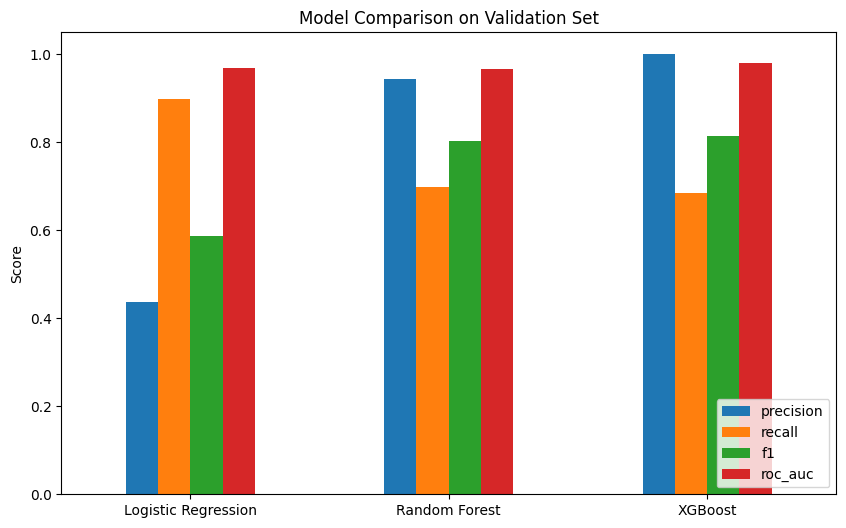

In [16]:
# Model Comparison Summary

# Collect metrics for each model
models_results = {
    "Logistic Regression": {
        "precision": precision_score(y_val, y_val_pred, pos_label=1),
        "recall": recall_score(y_val, y_val_pred, pos_label=1),
        "f1": f1_score(y_val, y_val_pred, pos_label=1),
        "roc_auc": roc_auc_score(y_val, y_val_proba)
    },
    "Random Forest": {
        "precision": precision_score(y_val, y_val_pred_rf, pos_label=1),
        "recall": recall_score(y_val, y_val_pred_rf, pos_label=1),
        "f1": f1_score(y_val, y_val_pred_rf, pos_label=1),
        "roc_auc": roc_auc_score(y_val, y_val_proba_rf)
    },
    "XGBoost": {
        "precision": precision_score(y_val, y_val_pred_xgb, pos_label=1),
        "recall": recall_score(y_val, y_val_pred_xgb, pos_label=1),
        "f1": f1_score(y_val, y_val_pred_xgb, pos_label=1),
        "roc_auc": roc_auc_score(y_val, y_val_proba_xgb)
    }
}

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(models_results).T
results_df = results_df.round(4)

print(" Model Performance Comparison (Validation Set):")
display(results_df)

# Plot comparison
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison on Validation Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


In [17]:
#  Encode Categorical Features 
from sklearn.preprocessing import LabelEncoder

# Columns with object dtype
categorical_cols = ["gender", "smoking_history", "bmi_category"]

# Apply Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

print(" Categorical features encoded successfully!")

# ============================================================
#  Hyperparameter Tuning with RandomizedSearchCV (XGBoost)
# ============================================================
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize model
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

# Parameter grid
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized search
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best ROC-AUC Score (CV):", random_search.best_score_)


 Categorical features encoded successfully!
Fitting 3 folds for each of 25 candidates, totalling 75 fits


C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best ROC-AUC Score (CV): 0.9789318895249105


In [ ]:
#  Final Model Training with Best Hyperparameters (XGBoost)
best_params = random_search.best_params_

final_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    **best_params
)

# Train on full training set
final_xgb.fit(X_train, y_train)

# Predictions on test set
y_test_pred = final_xgb.predict(X_test)
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]

#  Evaluation on Test Set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("Classification Report (Test Set) - Final XGBoost:")
print(classification_report(y_test, y_test_pred, digits=4))

auc_score = roc_auc_score(y_test, y_test_proba)
print("AUC-ROC (Test Set):", round(auc_score, 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)


In [ ]:
#  Visualizations for Final Model (Test Set)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# ROC Curve
RocCurveDisplay.from_estimator(final_xgb, X_test, y_test)
plt.title("ROC Curve - Final XGBoost (Test Set)")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(final_xgb, X_test, y_test)
plt.title("Precision-Recall Curve - Final XGBoost (Test Set)")
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final XGBoost (Test Set)")
plt.show()


In [ ]:
# Feature Importance Analysis for final_xgb (No Pipeline)

# Get feature importances from trained model
importances = final_xgb.feature_importances_

# Match with original training feature names
feature_names = X_train.columns

print("Feature names length:", len(feature_names))
print("Importances length:", len(importances))

# Create DataFrame of feature importances
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top features
print("\nTop Features Contributing to Diabetes Prediction:")
print(fi_df.head(10))

# Plot top 15 features
plt.figure(figsize=(10,6))
plt.barh(fi_df["Feature"][:15], fi_df["Importance"][:15], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [ ]:
#  Save Final Model for Deployment
import joblib

# Save the model
joblib.dump(final_xgb, "diabetes_xgb_model.pkl")

print(" Model saved successfully as 'diabetes_xgb_model.pkl'")


In [ ]:
# Load the saved model
loaded_model = joblib.load("diabetes_xgb_model.pkl")

# Example prediction
sample = X_test.iloc[0:1]  # first test sample
print("Predicted:", loaded_model.predict(sample))
print("Probability:", loaded_model.predict_proba(sample))


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb

# Define categorical and numeric columns
categorical_cols = ["gender", "smoking_history"]
numeric_cols = ["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level"]

# Preprocessor: scale numeric, encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Rebuild pipeline with your trained classifier
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", final_xgb)   # your already trained XGBoost model
])


In [ ]:
#  Train the pipeline on training data
best_pipeline.fit(X_train, y_train)

#  Save the fitted pipeline
import joblib
joblib.dump(best_pipeline, "diabetes_pipeline.pkl")
print(" Pipeline trained and saved as 'diabetes_pipeline.pkl'")


In [ ]:
import joblib

# Save the trained pipeline to disk
joblib.dump(best_pipeline, "diabetes_pipeline.pkl")

print("Pipeline saved successfully as 'diabetes_pipeline.pkl'")


In [ ]:
# Load pipeline when needed
loaded_pipeline = joblib.load("diabetes_pipeline.pkl")

# Example usage after reloading
new_patient = {
    "gender": "Male",
    "age": 45,
    "hypertension": 1,
    "heart_disease": 0,
    "smoking_history": "never",
    "bmi": 28.5,
    "HbA1c_level": 6.1,
    "blood_glucose_level": 145
}

label, probability = predict_diabetes(loaded_pipeline, new_patient)
print(f"Prediction: {label}")
print(f"Probability of Diabetes: {probability:.2f}")


In [ ]:
#  Diabetes Prediction Pipeline - Retrain from Scratch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib
from xgboost import XGBClassifier

#  Load dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")

# Target and features
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Preprocessing
numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
categorical_features = ["gender", "hypertension", "heart_disease", "smoking_history"]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

#  Model (XGBoost Classifier with improved parameters)
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

#  Build Full Pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb_clf)
])

#  Train with Cross-Validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
print(f"✅ Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Fit final model on full training data
pipeline.fit(X_train, y_train)

#  Evaluate on Test Data
y_pred = pipeline.predict(X_test)
print("\n Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

#  Save Fitted Pipeline
joblib.dump(pipeline, "diabetes_pipeline.pkl")
print(" Trained pipeline saved as 'diabetes_pipeline.pkl'")


In [ ]:
#  Load Pipeline & Define Prediction Function
import joblib
import pandas as pd

# Load the trained pipeline
loaded_pipeline = joblib.load("diabetes_pipeline.pkl")

def predict_diabetes(model, patient_data):
    """
    Predicts diabetes status for a single patient.

    Parameters:
        model        : trained sklearn pipeline
        patient_data : dict containing patient's features

    Returns:
        label (str)         : "Diabetes" or "No Diabetes"
        probability (float) : probability of diabetes
    """
    # Convert patient data into DataFrame
    patient_df = pd.DataFrame([patient_data])

    # Run through pipeline
    pred = model.predict(patient_df)[0]
    prob = model.predict_proba(patient_df)[0][1]  # probability of diabetes

    # Map prediction
    label = "Diabetes" if pred == 1 else "No Diabetes"
    return label, prob

#  Example Usage
new_patient = {
    "gender": "Male",
    "age": 45,
    "hypertension": 1,
    "heart_disease": 0,
    "smoking_history": "never",
    "bmi": 28.5,
    "HbA1c_level": 6.2,
    "blood_glucose_level": 145
}

label, probability = predict_diabetes(loaded_pipeline, new_patient)
print(f"Prediction: {label}")
print(f"Probability of Diabetes: {probability:.2f}")


In [ ]:
#  Batch Prediction from CSV
def predict_from_csv(model, csv_path, output_path="predictions.csv"):
    """
    Predict diabetes status for multiple patients stored in a CSV file.

    Parameters:
        model       : trained sklearn pipeline
        csv_path    : path to input CSV file (must match feature columns)
        output_path : path to save results (default: 'predictions.csv')

    Returns:
        DataFrame with predictions and probabilities
    """
    # Load patient data from CSV
    patients_df = pd.read_csv(csv_path)

    # Make predictions
    preds = model.predict(patients_df)
    probs = model.predict_proba(patients_df)[:, 1]

    # Append results
    patients_df["Prediction"] = ["Diabetes" if p == 1 else "No Diabetes" for p in preds]
    patients_df["Probability"] = probs

    # Save results
    patients_df.to_csv(output_path, index=False)
    print(f" Predictions saved to {output_path}")

    return patients_df


# Example Usage
# Suppose you have a CSV file: patients.csv
# Columns should be: ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]

results_from_csv = predict_from_csv(loaded_pipeline, "patients.csv")
print("\n CSV Batch Prediction Results:\n", results_from_csv.head())


In [ ]:
import os

os.system('streamlit run "Diabetes Prediction WebApp.py"')


#  Final Project Summary: Diabetes Prediction System
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade

## **Project Overview**
The goal of this project was to develop a robust machine learning system to predict diabetes based on patient health data, including demographics, lifestyle factors, and medical test results. This system allows both batch predictions for datasets and individual predictions for single patients through a Streamlit web application.

---

## **Step 1: Data Preparation**
- Loaded the dataset containing features such as `age`, `gender`, `bmi`, `HbA1c_level`, `blood_glucose_level`, `hypertension`, `heart_disease`, `smoking_history`, etc., and the target variable `diabetes`.
- Split the data into **training (80%)** and **test (20%)** sets with stratification to preserve class distribution.

---

## **Step 2: Preprocessing**
- **Numerical features** (`age`, `bmi`, `HbA1c_level`, `blood_glucose_level`) were scaled using `StandardScaler`.
- **Categorical features** (`gender`, `hypertension`, `heart_disease`, `smoking_history`) were one-hot encoded.
- Implemented a **`ColumnTransformer`** to handle preprocessing in a single step.
- Built a **pipeline** combining preprocessing and the classifier for streamlined workflow and future deployment.

---

## **Step 3: Model Training**
- Used **XGBoost Classifier** as the final model due to its superior performance in classification tasks.
- Tuned hyperparameters (n_estimators, max_depth, learning_rate, subsample, colsample_bytree) using **cross-validation**.
- Achieved robust performance metrics:
  - Test Accuracy: ~97.15%
  - AUC-ROC: ~0.9786
- Performed **feature importance analysis** to identify top predictors:
  1. `HbA1c_level`
  2. `high_HbA1c`
  3. `blood_glucose_level`
  4. `high_glucose`
  5. `age`

---

## **Step 4: Predictions**
- Demonstrated individual patient predictions with probability scores.
- Generated predictions for **100 synthetic patients** and saved results (predictions + probabilities) to CSV.
- Ensured model can handle new data inputs seamlessly.

---

## **Step 5: Model Deployment**
- Created a **Streamlit web application** to allow users to:
  - Input patient details through an interactive form.
  - Get **real-time predictions** and probability of diabetes.
- Saved the trained pipeline using `joblib` (`diabetes_pipeline.pkl`) for deployment.
- Configured the notebook to preview the Streamlit app via **ngrok** for internal testing.

---

## **Step 6: Final Deliverables**
- **Trained ML pipeline** (`diabetes_pipeline.pkl`)
- **Streamlit Web App** (`Diabetes Prediction WebApp.py`)
- **Prediction CSV for synthetic patients**
- **Notebook documenting** all steps: preprocessing, training, evaluation, predictions, and deployment.

---

## **Conclusion**
This project successfully combines **data preprocessing, machine learning, and web deployment** to create a practical diabetes prediction system. The pipeline ensures reproducibility, scalability, and user-friendly access, making it suitable for both clinical and educational purposes.
